# Normal Crossing RLCT Estimation

This notebook is measures the RLCT of normal crossings using two algorithms: SGNHT (Stochastic Gradient Nose-Hoover Thermostat) and SGLD (Stochastic Gradient Langevin Dynamics). The target model is a polynomial model characterized by $w_1^a * w_2^b$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned. The data generated around a given point $w_0$ with gaussian noise, so the model achieves its lowest loss when $w_1=0$ or $w_2 =0$. We estimate the RLCTs at the origin, and at points where either $w_1=0$ or $w_2=0$, but not both.

In [1]:
import math
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import seaborn as sns
import torch
from torch.optim.sgd import SGD
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm

if "google.colab" in sys.modules:
    %pip install git+https://github.com/timaeus-research/devinterp.git@add/colab
sys.path.append("/home/paperspace/devinterp/")
from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT
from devinterp.slt.sampler import estimate_rlct, sample

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
sns.set_style('whitegrid')





In [2]:
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in tqdm(train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def train_one_batch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        break
    return train_loss


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    model.train()
    return test_loss / len(test_loader)

In [3]:
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor([1.0, 0.3], dtype=torch.float32, requires_grad=True)
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x * multiplied
        return x


powers = torch.tensor([2, 2]) 
model = PolyModel(powers)
sigma = 0.25
lr = 0.0005
num_train_samples = 5000
num_test_samples = 1000
batch_size = num_train_samples
w_true = torch.zeros_like(powers)

x = torch.normal(0, 2, size=(num_train_samples,))
y = sigma * torch.normal(0, 1, size=(num_train_samples,))
train_data = TensorDataset(x, y)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
rlct_estimates = []
criterion = F.mse_loss
test_loss = 0.0


def print_rlcts(n_estimates=50):
    rlct_estimates_sgnht = []
    rlct_estimates_sgdl = []
    for _ in range(n_estimates):
        rlct_estimate_sgnht = estimate_rlct(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=lr,
                diffusion_factor=0.01,
                bounding_box_size=1.0,
                num_samples=len(train_data),
                batch_size=batch_size,
            ),
            sampling_method=SGNHT,
            num_chains=1,
            num_draws=1_000,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            verbose=False,
        )
        rlct_estimate_sgdl = estimate_rlct(
            model,
            train_loader,
            criterion=criterion,
            optimizer_kwargs=dict(
                lr=lr,
                bounding_box_size=1.0,
                elasticity=1.0,
                temperature="adaptive",
                num_samples=len(train_data),
            ),
            sampling_method=SGLD,
            num_chains=1,
            num_draws=1_000,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            verbose=False,
        )

        if not math.isnan(rlct_estimate_sgnht):
            rlct_estimates_sgnht += [rlct_estimate_sgnht]
        if not math.isnan(rlct_estimate_sgdl):
            rlct_estimates_sgdl += [rlct_estimate_sgdl]
    plt.hist(rlct_estimates_sgnht, alpha=0.5, label="sgnht")
    plt.hist(rlct_estimates_sgdl, alpha=0.5, label="sgdl")
    plt.legend()
    plt.show()

    print(
        f"estimated rlct: sgnht: {np.mean(rlct_estimates_sgnht)}, sgdl: {np.mean(rlct_estimates_sgdl)}"
    )

In [4]:
model.weights = nn.Parameter(
    torch.tensor([0.0, 0.0], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

model.weights = nn.Parameter(
    torch.tensor([2.0, 0.0], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

model.weights = nn.Parameter(
    torch.tensor([0.0, 3.0], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

model.weights = nn.Parameter(
    torch.tensor([0.01, 0.01], dtype=torch.float32, requires_grad=True)
)
print_rlcts()

In [5]:
# plotting
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))

lighter_factor = 0.9  # Between 0 and 1, higher values make it closer to white
lighter_SECONDARY = tuple([x + (1-x) * lighter_factor for x in hex_to_rgb(SECONDARY)[:3]] + [1.]) 

colors = [SECONDARY,lighter_SECONDARY]  
n_bins = 20  # Number of bins
contour_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

def plot_trajectories(trajectories, names):
    fig, axes = plt.subplots(1, len(trajectories), figsize=(14, 6))
    w1_range = np.linspace(-2, 2, 21)
    w2_range = np.linspace(-2, 2, 21)
    w1_vals, w2_vals = np.meshgrid(w1_range, w2_range)
    Z = np.zeros_like(w1_vals, dtype=float)

    for i in range(w1_vals.shape[0]):
        for j in range(w1_vals.shape[1]):
            w1 = w1_vals[i, j]
            w2 = w2_vals[i, j]
            model.weights = nn.Parameter(torch.tensor([w1, w2], dtype=torch.float32))
            Z[i, j] = model(torch.tensor(1.0)).item()

    custom_levels = np.linspace(Z.min(), Z.max() * 0.04, n_bins)

    for i, trajectory in enumerate(trajectories):
        axes[i].contourf(w1_vals, w2_vals, Z, levels=custom_levels, cmap=contour_cmap, alpha=1)
        weights = trajectory["model_weights"]
        draws_array = np.array(
            [
                d
                for d in weights
                if w1_range[0] <= d[0] <= w1_range[-1]
                and w2_range[0] <= d[1] <= w2_range[-1]
            ]
        )
        sns.scatterplot(x=draws_array[:, 0], y=draws_array[:, 1], marker='x',ax=axes[i], s=10,  color=PRIMARY)
        axes[i].axhline(0,  linestyle='--',  color=TERTIARY)
        axes[i].axvline(0,  linestyle='--', color=TERTIARY)
        axes[i].set_xlabel(r'$w_{1}$')
        axes[i].set_ylabel(r'$w_{2}$')
        axes[i].set_title(names[i])
        axes[i].grid(False)
    plt.show()



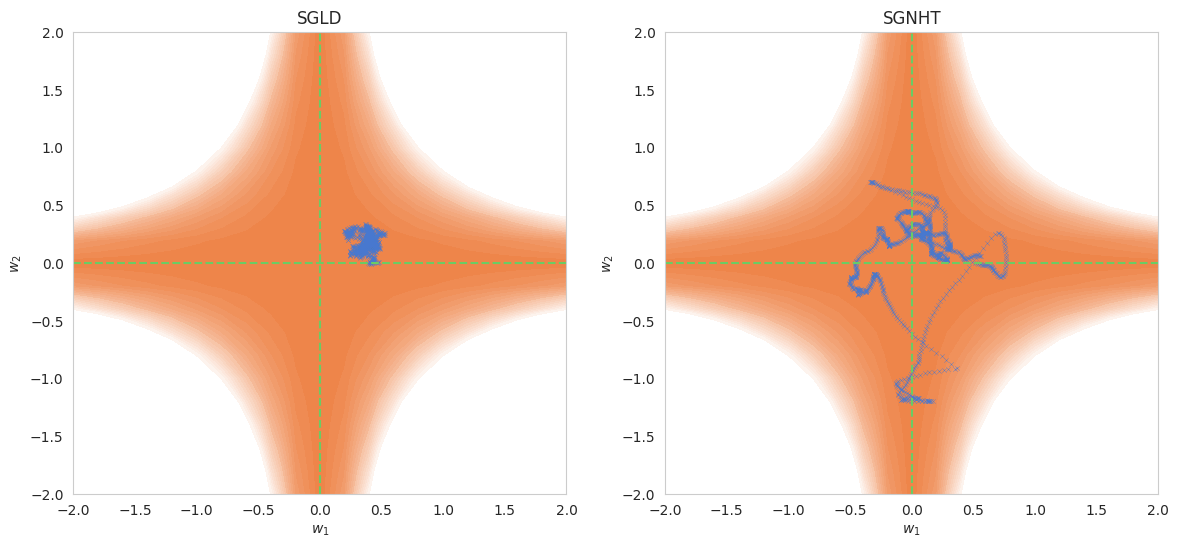

In [6]:
lr = 0.0001
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([.5, 0.01], dtype=torch.float32, requires_grad=True)
)
trace_sgnht = sample(
    model,
    train_loader,
    criterion=criterion,
    optimizer_kwargs=dict(
        lr=lr,
        diffusion_factor=0.01,
        num_samples=len(train_data),
    ),
    sampling_method=SGNHT,
    num_chains=1,
    num_draws=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
)
torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([.5, 0.01], dtype=torch.float32, requires_grad=True)
)
trace_sgld = sample(
    model,
    train_loader,
    criterion=criterion,
    optimizer_kwargs=dict(
        lr=lr,
        elasticity=1.0,
        temperature="adaptive",
        num_samples=len(train_data),
    ),
    sampling_method=SGLD,
    num_chains=1,
    num_draws=1_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
)
plot_trajectories([trace_sgld,trace_sgnht], names = ['SGLD', 'SGNHT'])


Sample: 100%|██████████| 520/520 [00:33, 15.76it/s, step size=1.44e+00, acc. prob=0.413]


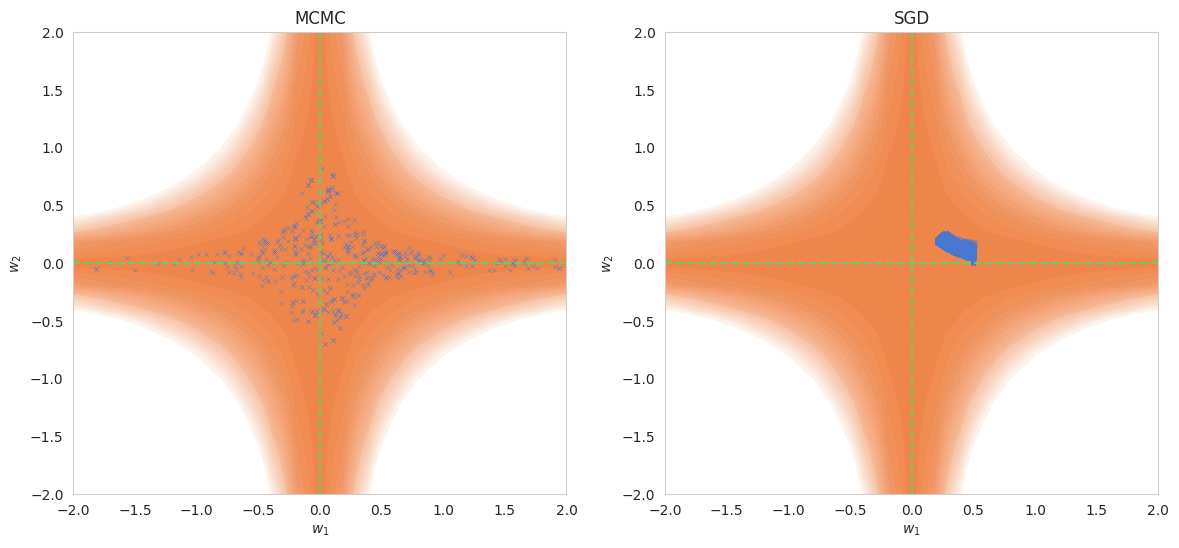

In [29]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

torch.manual_seed(0)
np.random.seed(0)
model.weights = nn.Parameter(
    torch.tensor([.5, 0.01], dtype=torch.float32, requires_grad=True)
)
trace_sgd = sample(
    model,
    train_loader,
    criterion=criterion,
    optimizer_kwargs=dict(lr=1_000 * lr),
    sampling_method=SGD,
    num_chains=1,
    num_draws=100_000,
    num_burnin_steps=0,
    num_steps_bw_draws=1,
    verbose=False,
    return_weights=True,
)
torch.manual_seed(0)
np.random.seed(0)
# Define a Pyro model for Bayesian inference
w_prior = dist.Normal(model.weights, torch.ones_like(model.weights)).to_event(1)

def pyro_model(x, y):
    w = pyro.sample("weights", w_prior)
    model.weights = nn.Parameter(w)
    y_pred = model(x)
    pyro.sample("obs", dist.Normal(y_pred, 0.5), obs=y)

# Perform MCMC sampling using NUTS
nuts_kernel = NUTS(pyro_model)
mcmc = MCMC(nuts_kernel, num_samples=500, warmup_steps=20)
mcmc.run(x, y)

# Get posterior samples
posterior_samples = mcmc.get_samples()
trace_mcmc = {'model_weights':posterior_samples["weights"]}
plot_trajectories([trace_mcmc, trace_sgd], names = ['MCMC-NUTS', 'SGD'])


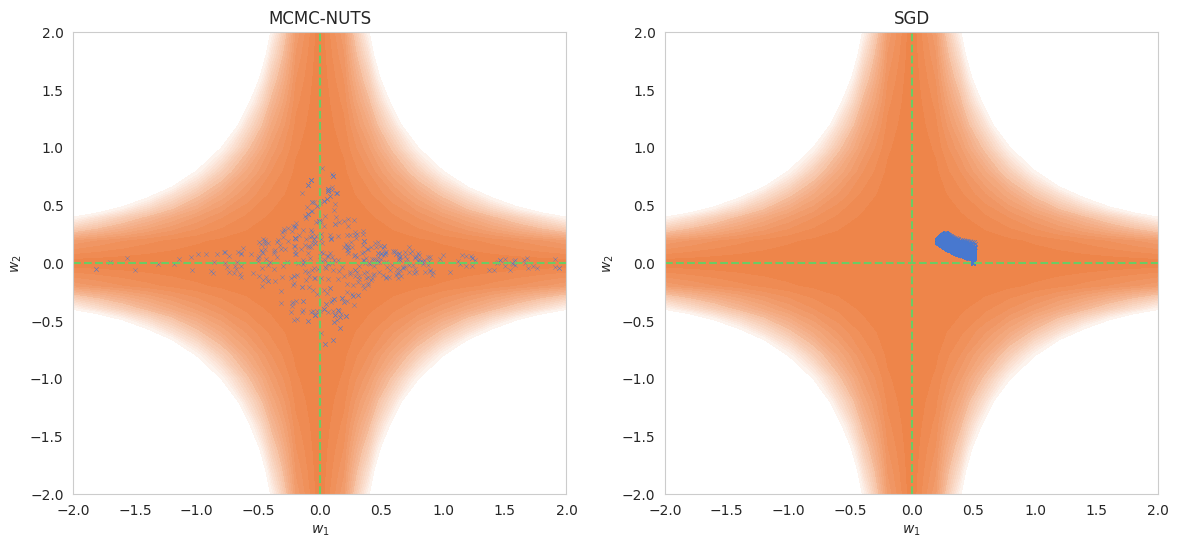

In [30]:
plot_trajectories([trace_mcmc, trace_sgd], names = ['MCMC-NUTS', 'SGD'])
